In [1]:
import pandas as pd
import numpy as n
import pickle
import re
from pathlib import Path
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

"""
root = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
while root.parent != root:
    if ((root / ".git").exists() and 
        (root / "README.txt").exists() and 
        (root / "results.ipynb").exists()): break
    root = root.parent
if str(root) not in sys.path: sys.path.insert(0, str(root))

print("Root folder at: ", root)"""

# Detect root starting from this file or from notebook’s cwd
try:
    start_path = Path(__file__).resolve()
except NameError:
    start_path = Path.cwd()

root = start_path
while root != root.parent:
    # Check for any known project markers
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
        break
    root = root.parent

# Sanity check — fallback if nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
    print("⚠️ Project root not found — defaulting to current working directory")
    root = Path.cwd()

print(f"✅ Root folder detected at: {root}")

# Add project root to sys.path if not already
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

from src.utils.paths import *
from src.utils.general_utils import *

stored_dataprep_pkl_path = root / STORED_DATAPREP_PKL_PATH
with open(stored_dataprep_pkl_path, "rb") as f:
    data = pickle.load(f)

✅ Root folder detected at: /Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42


In [2]:
from textblob import TextBlob
import nltk
from collections import Counter
import re
import numpy as np
from textblob import download_corpora
#run this in the terminal : python -m textblob.download_corpora 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/todorovkatia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/todorovkatia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/todorovkatia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/todorovkatia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1. Data preparation


In [3]:
dataA = data['dataA']

dfs_with_id = [
    df.assign(source_id=i)   # ajoute une colonne avec l’indice du DF
    for i, df in enumerate(dataA)
]

# Concaténation des DataFrames
dataAm2 = pd.concat(dfs_with_id, ignore_index=True)
dataAm2.sort_values(by='funny_score_scaled', ascending=False, inplace=True)
print(dataAm2.shape)
dataAm2_2=dataAm2.drop_duplicates()
print(dataAm2_2.shape)

(2292678, 11)
(2292354, 11)


In [4]:
rows = dataAm2_2[dataAm2_2['caption'].str.contains('hitchhikers', case=False, na=False)]


In [9]:
rows["source_id"].unique()

array([ 94,  40, 159, 286,  24, 317,  95, 296, 378,  21, 134, 135,  88])

In [41]:
from src.utils.general_utils import *
absolute_index2contest_index(317)

829

In [43]:
contest_index2absolute_index(733)

221

In [14]:
df_hitch =dataA[94]

In [42]:
df_hitch["caption"][236]

'Is this Part 2 of Hitchhikers Guide to The Galaxy?'

In [34]:
df_hitch["caption"][17]
df_hitch_rows = df_hitch[df_hitch['caption'].str.contains('hitchhikers', case=False, na=False)]
df_hitch_rows 


,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,funny_score_scaled,funny_group
87,Hitchhikers I can take. What I really hate are...,1.541667,0.159018,24,15,5,4,0.34,32.976959,funny
169,You're right. There's nothing in the manual ab...,1.473684,0.177184,19,13,3,3,-0.55,31.336406,funny
236,Is this Part 2 of Hitchhikers Guide to The Gal...,1.400000,0.163299,15,10,4,1,-0.92,30.654378,mid_funny
508,"Hold up, let me grab my Hitchhikers Guide to t...",1.272727,0.140836,11,8,3,0,-1.92,28.811060,mid_funny
514,"Bob, you know the rules, no hitchhikers.",1.272727,0.140836,11,8,3,0,-1.92,28.811060,mid_funny
...,...,...,...,...,...,...,...,...,...,...
6242,"""The hitchhikers guide to the galaxy""devotees ...",1.000000,0.182574,6,6,0,0,-3.89,25.179724,mid_funny
6259,Hitchhikers these days.,1.000000,0.182574,6,6,0,0,-3.89,25.179724,mid_funny
6279,I never pick-up hitchhikers.,1.000000,0.182574,6,6,0,0,-3.89,25.179724,mid_funny
6299,I think the manual prohibits picking up hitchh...,1.000000,0.182574,6,6,0,0,-3.89,25.179724,mid_funny


In [5]:
from tqdm import tqdm
results_blob = []
#subset_test_rf =dataAm2_2.loc[30000:100000,] 
#ubset_test_rf = subset_test_rf.reset_index().rename(columns={"index": "caption_id"})
dataAm2_2 = dataAm2_2.reset_index().rename(columns={"index": "caption_id"})
for i, cap in tqdm(zip(dataAm2_2['caption_id'], dataAm2_2['caption']), total=len(dataAm2_2)):
    blob = TextBlob(cap)
    results_blob.append({
        'caption_id': i,
        'polarity': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity,
        'num_words': len(blob.words),
        'num_punct': len(re.findall(r'[^\w\s]', cap)),
        'num_repeats': len(re.findall(r'\b(\w+)\s+\1\b', cap.lower()))
    })

df_blob = pd.DataFrame(results_blob)

dataAm_rf = dataAm2_2.merge(df_blob, on="caption_id", how="inner")

100%|██████████| 2292354/2292354 [03:31<00:00, 10859.20it/s]


In [6]:
dataAm_rf= dataAm_rf[dataAm_rf["num_words"]<80]

In [7]:
low_threshold = dataAm_rf["funny_score_scaled"].quantile(0.0001)
high_threshold = dataAm_rf["funny_score_scaled"].quantile(0.9999)

print(f"Low (5%) threshold: {low_threshold}")
print(f"High (95%) threshold: {high_threshold}")
def assign_group(row, high_threshold, low_threshold):
    if row['funny_score_scaled'] >= high_threshold:
        return 'funny'
    elif row['funny_score_scaled'] <= low_threshold:
        return 'not_funny'
    else:
        return 'mid_funny'
dataAm_rf["funny_group3"] = dataAm_rf.apply(assign_group, axis=1, high_threshold=high_threshold, low_threshold=low_threshold)


Low (5%) threshold: 3.473942857142859
High (95%) threshold: 66.78341013824885


In [ ]:
"""mean = dataAm_rf["funny_score_scaled"].mean()
sd = dataAm_rf["funny_score_scaled"].std()
high_treshold = mean+3*sd
low_treshold = mean-3*sd
print(f"Hign and low threshold are : {high_treshold}, {low_treshold}")

def assign_group(row,high_threshold, low_threshold):
    if row['funny_score_scaled'] >=high_threshold:
        return 'funny'
    elif row['funny_score_scaled'] <=low_threshold:
        return 'not_funny'
    else:
        return 'mid_funny'
    
dataAm_rf["funny_group2"] = dataAm_rf.apply(assign_group, axis=1, high_threshold=high_treshold, low_threshold=low_treshold)"""

Hign and low threshold are : 35.02994662106491, 12.450998528865446


In [9]:
dataAm_rf_filtered = dataAm_rf[dataAm_rf["funny_group3"] != 'mid_funny']

In [10]:
dataAm_rf.groupby('funny_group3').describe()
dataAm_rf.groupby('funny_group3')["source_id"].nunique()


funny_group3
funny         84
mid_funny    384
not_funny      4
Name: source_id, dtype: int64

In [11]:
df_funny =dataAm_rf[dataAm_rf["funny_group3"] == 'funny']

In [170]:
df_funny["source_id"].unique()
#not funny = 80, 79, 88, 87
#absolute_index2contest_index(87)
#592, 591, 600, 599


array([153,  88, 188, 189, 168, 199, 172, 220, 198, 159, 200,  43, 116,
       170, 118, 197, 195, 192, 169, 193, 187, 162, 148, 190, 221, 203,
       157, 155, 176, 226, 178, 152, 229, 151, 150, 214, 186, 213, 182,
       120, 210, 201, 227, 181, 115, 149, 191,  72, 222, 225,  63, 113,
       194, 228, 167, 223, 217, 111, 165, 202, 174,  20, 156, 154, 205,
       206, 179,  66, 166, 175,  74,  25, 215,  65, 171, 212, 163, 112,
       108, 109, 160, 211, 173, 184])

In [12]:
dataAm_rf.groupby('funny_group3').agg(
    total_rows=("source_id", "count"),
    unique_caption=("source_id", "nunique")
)

,total_rows,unique_caption
funny_group3,,
funny,231,84
mid_funny,2291847,384
not_funny,230,4


## 2. Plot exploration

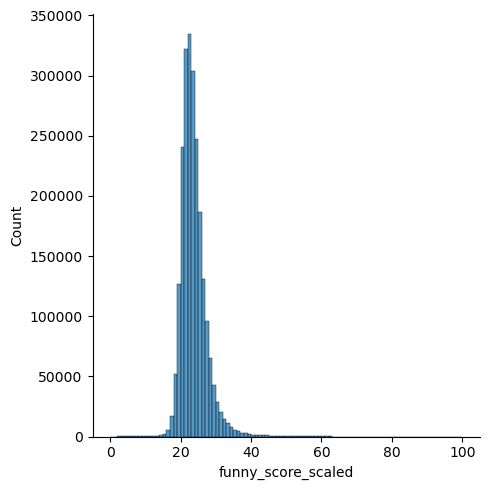

In [13]:
sns.displot(dataAm_rf, x="funny_score_scaled", bins=100)

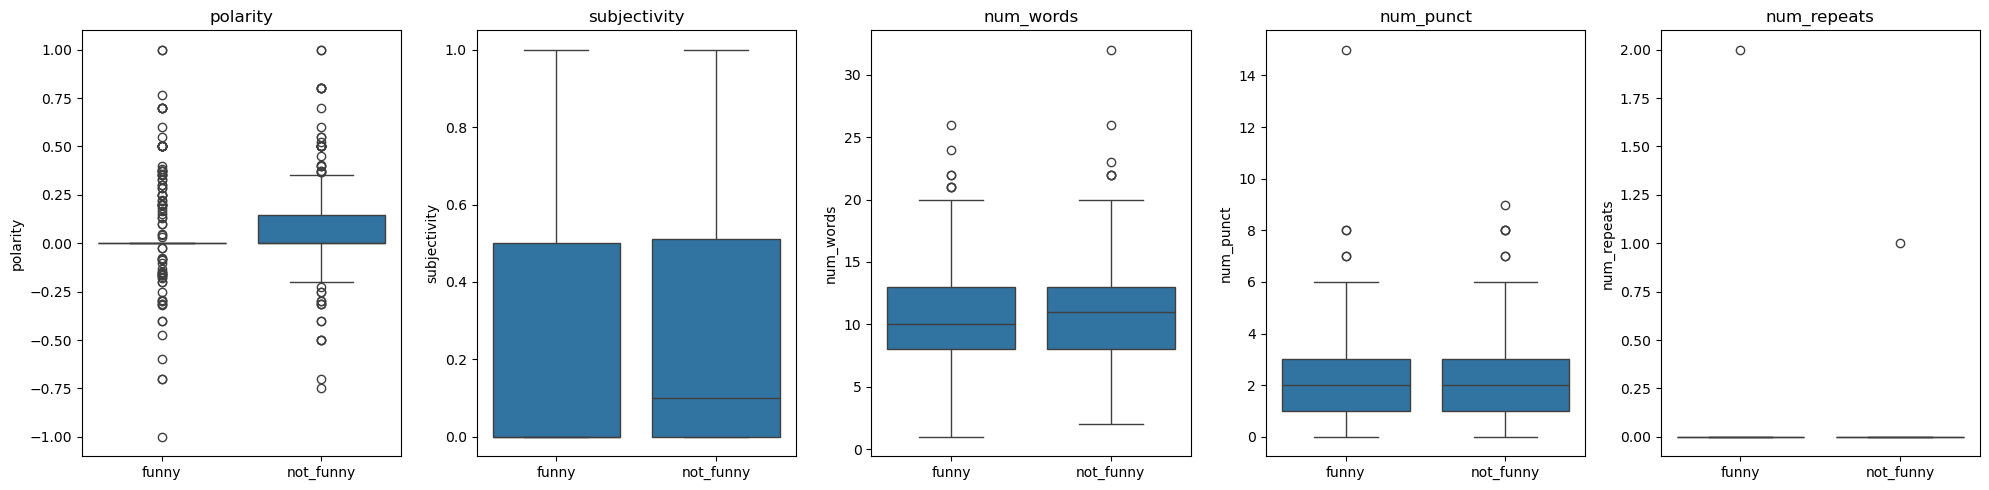

In [14]:
features = ['polarity', 'subjectivity', 'num_words', 'num_punct', 'num_repeats']

fig, axes = plt.subplots(1, len(features), figsize=(20, 5), sharey=False)

for ax, f in zip(axes, features):
    sns.boxplot(
        x='funny_group3',
        y=f,
        data=dataAm_rf_filtered,
        ax=ax
    )
    ax.set_title(f)
    ax.set_xlabel('')
    
plt.tight_layout()
plt.show()
#sns.boxplot(x='funny_group3', y=f , data=dataAm_rf_filtered)


## 2.2 Data exploration

In [12]:
dataAm_rf.columns

Index(['caption_id', 'caption', 'mean', 'precision', 'votes', 'not_funny',
       'somewhat_funny', 'funny', 'funny_score', 'funny_score_scaled',
       'funny_group', 'source_id', 'polarity', 'subjectivity', 'num_words',
       'num_punct', 'num_repeats'],
      dtype='object')

In [ ]:
dataAm_rf.groupby('funny_group').describe()

caption_id                                                    \
                 count          mean            std       min        25%   
funny_group                                                                
funny          78775.0  1.100331e+06  641069.860817       0.0  529347.50   
mid_funny    2207081.0  1.149784e+06  662487.511484      40.0  577970.00   
not_funny       6452.0  5.702293e+05  315565.042933  103218.0  417571.75   

                                                    mean            ...  \
                   50%         75%        max      count      mean  ...   
funny_group                                                         ...   
funny        1235143.0  1606227.50  2287821.0    78775.0  1.573203  ...   
mid_funny    1146884.0  1727243.00  2292676.0  2207081.0  1.200693  ...   
not_funny     458036.5   667102.25  2292677.0     6452.0  1.014100  ...   

            num_punct        num_repeats                                     \
                  75%    max       count      mean       std  min  25%  50%   
funny_group                                                                   
funny             3.0   35.0     78775.0  0.002031  0.051592  0.0  0.0  0.0   
mid_funny         3.0  235.0   2207081.0  0.004129  0.081768  0.0  0.0  0.0   
not_funny         3.0   30.0      6452.0  0.006200  0.089567  0.0  0.0  0.0   

                        
             75%   max  
funny_group             
funny        0.0   6.0  
mid_funny    0.0  25.0  
not_funny    0.0   4.0  

[3 rows x 120 columns]

In [15]:
from scipy.stats import anderson

result = anderson(dataAm_rf["funny_score_scaled"], dist='norm')
print(result)
## Funny score scaled n'a pas une distribution normale


AndersonResult(statistic=np.float64(50595.25888574589), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(23.740472574965178), scale=np.float64(3.7631580153665776))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [82]:
dataAm_rf.columns

Index(['caption_id', 'caption', 'mean', 'precision', 'votes', 'not_funny',
       'somewhat_funny', 'funny', 'funny_score', 'funny_score_scaled',
       'funny_group', 'source_id', 'polarity', 'subjectivity', 'num_words',
       'num_punct', 'num_repeats', 'funny_group2', 'funny_group3'],
      dtype='object')

In [8]:
best = dataAm_rf[dataAm_rf["funny_score_scaled"]==100]
best
worth = dataAm_rf[dataAm_rf["funny_score_scaled"]==0]
worth
#pictures_best = best['image_id'].unique()
best_contest = absolute_index2contest_index(best.iloc[0]["source_id"])
contest_worth = absolute_index2contest_index(worth.iloc[0]["source_id"])
print(best_contest)
worth.iloc[0]["source_id"]
display(worth)


665


,caption_id,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,funny_score_scaled,funny_group,source_id,polarity,subjectivity,num_words,num_punct,num_repeats,funny_group3
2292353,418104,"We're not getting Shakespeare, but about every...",1.0,0.000155,6467,6467,0,0,-17.55,0.0,not_funny,80,0.0,0.0,15,3,0,not_funny


In [179]:
best["caption"]

0    Lunch is on me.
Name: caption, dtype: object

In [ ]:
worth["caption"]
#"We're not getting Shakespeare, but about every three minutes we get a presidential tweet.“

2292353    We're not getting Shakespeare, but about every...
Name: caption, dtype: object

In [ ]:
path_worth = f"{root}/data/newyorker_caption_contest_virgin/images/{contest_worth}.jpg"
path_worth

'/Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42/data/newyorker_caption_contest_virgin/images/592.jpg'

In [114]:
root

PosixPath('/Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42')

In [119]:
# Construire le chemin
path_worth = os.path.join( f"{root}/data/newyorker_caption_contest_virgin/images/", f"{contest_worth}.jpg")
path_best = os.path.join( f"{root}/data/newyorker_caption_contest_virgin/images/", f"{best_contest}.jpg")

# Vérifier le chemin
print(path_best)
print(os.path.exists(path_best))

/Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42/data/newyorker_caption_contest_virgin/images/665.jpg
True


In [120]:
from PIL import Image

# Open the image
img = Image.open(path_best)

# Display
img.show() 

### Find Best and worth in all df


In [12]:
idx_best = dataAm_rf.groupby("source_id")["funny_score_scaled"].idxmax()
idx_worst = dataAm_rf.groupby("source_id")["funny_score_scaled"].idxmin()
df_best = dataAm_rf.loc[idx_best].copy()
df_best["caption_type"] = "best"

df_worst = dataAm_rf.loc[idx_worst].copy()
df_worst["caption_type"] = "worst"
df_combined = pd.concat([df_best, df_worst], ignore_index=True)

In [13]:
print(df_best.shape)
print(df_worst.shape)
df_combined.shape

(384, 19)
(384, 19)


(768, 19)

In [22]:
#ols tentative
import statsmodels.formula.api as smf
df_combined.loc[:, "category"] = np.where(df_combined['caption_type'] == "best", '1', '0')
df = df_combined.copy()
df['num_words'] = (df['num_words'] - df['num_words'].mean())/df['num_words'].std()
df['polarity'] = (df['polarity'] - df['polarity'].mean())/df['polarity'].std()
df['subjectivity'] = (df['subjectivity'] - df['subjectivity'].mean())/df['subjectivity'].std()
df['num_repeats'] = (df['num_repeats'] - df['num_repeats'].mean())/df['num_repeats'].std()
df['num_punct'] = (df['num_punct'] - df['num_punct'].mean())/df['num_punct'].std()
df["category"] = df["category"].astype(int)
mod = smf.logit(formula='category ~  num_words + polarity + subjectivity + num_repeats + \
                        num_punct ', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.662540
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               category   No. Observations:                  768
Model:                          Logit   Df Residuals:                      762
Method:                           MLE   Df Model:                            5
Date:                Sat, 20 Dec 2025   Pseudo R-squ.:                 0.04416
Time:                        13:16:54   Log-Likelihood:                -508.83
converged:                       True   LL-Null:                       -532.34
Covariance Type:            nonrobust   LLR p-value:                 5.650e-09
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0238      0.075     -0.317      0.751      -0.171       0.123
num_words       -0.5159

In [18]:
#display(df_best.sort_values(by="funny_score_scaled", ascending=False).head(10))
display(df)

,caption_id,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,funny_score_scaled,funny_group,source_id,polarity,subjectivity,num_words,num_punct,num_repeats,funny_group3,caption_type,category
0,0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,6.74,44.774194,funny,0,-0.241709,-0.840150,-0.559192,0.508447,-0.088678,mid_funny,best,1
1,3905,I'm hourly.,1.860465,0.127074,43,18,13,12,4.97,41.511521,funny,1,-0.241709,-0.840150,-1.270926,-0.377012,-0.088678,mid_funny,best,1
2,7230,"We're pretentious, not ostentatious.",2.250000,0.168005,32,11,2,19,8.52,48.055300,funny,2,-1.469960,1.340695,-0.986232,0.065718,-0.088678,mid_funny,best,1
3,11629,"I'm just saying, I can see why the 'brief'case...",2.111111,0.260579,9,2,4,3,5.37,42.248848,funny,3,1.259486,0.959913,0.152541,0.951177,-0.088678,mid_funny,best,1
4,15770,"Sheriff, I feel like we're just going through ...",1.918605,0.053714,172,50,86,36,8.84,48.645161,funny,4,-0.241709,-0.840150,0.010194,0.065718,-0.088678,mid_funny,best,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,2270861,I call it the 'Curveball Strategy' – guarantee...,1.000000,0.008889,113,113,0,0,-9.47,14.894009,not_funny,379,-1.265251,-0.684375,0.437234,0.508447,-0.088678,mid_funny,worst,0
764,2276049,Are you still hungry?,1.040404,0.019890,99,95,4,0,-8.37,16.921659,mid_funny,380,-0.241709,-0.840150,-1.128579,-0.819741,-0.088678,mid_funny,worst,0
765,2281562,"I know what you're thinking, but when you leav...",1.031579,0.018037,95,92,3,0,-8.48,16.718894,mid_funny,381,-0.241709,-0.840150,0.294887,0.951177,-0.088678,mid_funny,worst,0
766,2287719,My chimp can paint better than that,1.020202,0.014212,99,97,2,0,-8.79,16.147465,not_funny,382,1.805375,0.717597,-0.701539,-1.262471,-0.088678,mid_funny,worst,0


## 3. statistical test

In [62]:
from scipy.stats import ttest_ind
for f in features:
    g1 = dataAm_rf_filtered.loc[dataAm_rf_filtered['funny_group3'] == 'funny', f]
    g2 = dataAm_rf_filtered.loc[dataAm_rf_filtered['funny_group3'] == 'not_funny', f]

    t_stat, p_val = ttest_ind(g1, g2, equal_var=False)
    if p_val < 0.05:
        print(f"For {f} varibale : T-statistic: {t_stat}, P-value: {p_val} => Reject null hypothesis")
    else:   
        print(f"For {f} varibale : T-statistic: {t_stat}, P-value: {p_val}")

For polarity varibale : T-statistic: -0.9876455797312343, P-value: 0.32384722101489305
For subjectivity varibale : T-statistic: -2.203730584159546, P-value: 0.028046283668570884 => Reject null hypothesis
For num_words varibale : T-statistic: -0.6963916935356878, P-value: 0.48653653043938894
For num_punct varibale : T-statistic: -0.29385975381677965, P-value: 0.7689983847291602
For num_repeats varibale : T-statistic: 0.44488166273935714, P-value: 0.6566892067800189


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for feat in list_features:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=dataAm_rf, x='funny_group', y=feat)
    plt.title(f"Distribution of {feat} by Funny Group")
    plt.xlabel("Funny Group")
    plt.ylabel(feat)
    plt.grid(axis="y", alpha=0.3)
    plt.show()


## 4. Beau plot

#### 1. Non-interactive plot for result file

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np


In [41]:
def plot_boxplot_static(df, columns_category, features, save_fig=False, title=None,figsize_per_feature=4):
    feature_labels = {
        'polarity': 'Sentiment Polarity',
        'subjectivity': 'Subjectivity',
        'num_words': 'Number of Words',
        'num_punct': 'Number of Punctuations',
        'num_repeats': 'Repetitions'
    }

    groups = df[columns_category].unique()

    fig, axes = plt.subplots(1, len(features), figsize=(figsize_per_feature * len(features),5),sharey=False)

    if len(features) == 1:
        axes = [axes]

    for i, f in enumerate(features):
        ax = axes[i]

        sns.boxplot(
            data=df,
            x=columns_category,
            y=f,
            ax=ax,
            hue=columns_category,
            palette=["green", "orange"]
        )
        #sns.set_theme(style="whitegrid")

        ax.set_title(feature_labels.get(f, f))
        ax.set_xlabel("")
        ax.tick_params(axis='x', rotation=0)
        plt.grid(True, linestyle='-', alpha=0.6)
        plt.gca().set_axisbelow(True)

        # Statistical test
        g1 = df[df[columns_category] == groups[0]][f]
        g2 = df[df[columns_category] == groups[1]][f]
        t_stat, p_val = ttest_ind(g1, g2, equal_var=False)

        # Annotation p-value
        y_max = df[f].max()
        text = f"p = {p_val:.2e}"
        if p_val < 0.05:
            text += " *"

        ax.text(
            0.5,
            0.9,
            text,
            ha='center',
            va='bottom',
            fontsize=11,
            transform=ax.get_xaxis_transform()
        )

    # Title global
    if columns_category == "caption_type":
        suptitle = "Comparison of best and worst captions in each contest"
    else:
        suptitle = "Comparison of best and worst captions overall contests"

    plt.suptitle(suptitle, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])


    if save_fig:
        plt.savefig(f"boxplot_{title}.png", dpi=300)

    plt.show()


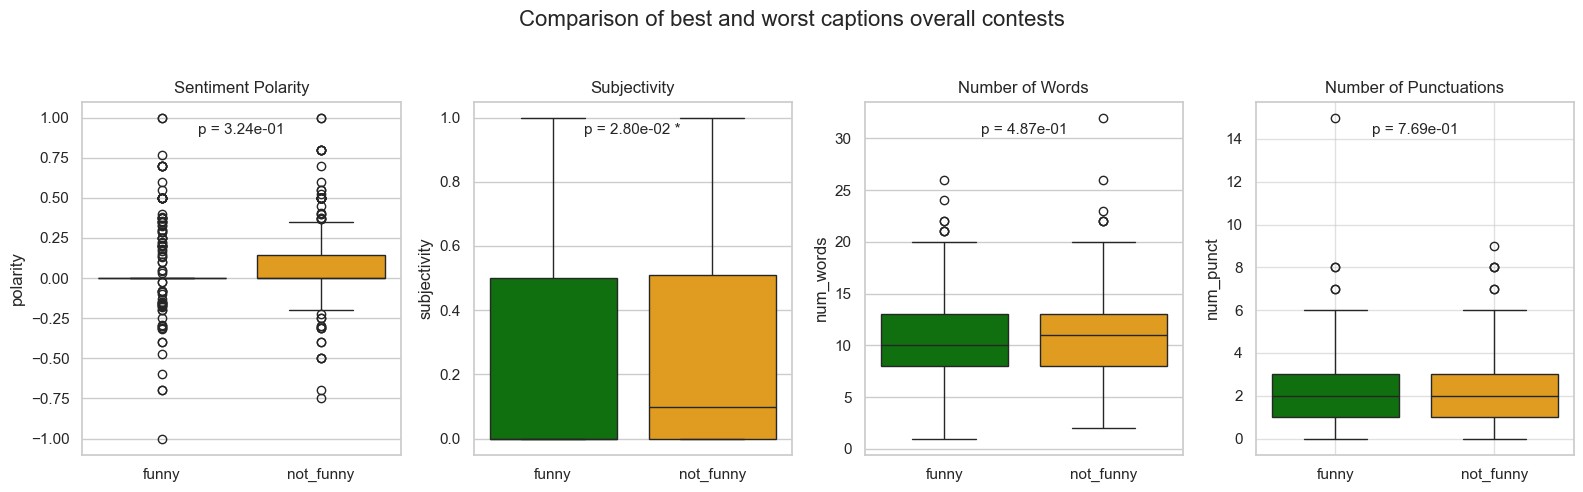

In [ ]:
features = ['polarity', 'subjectivity', 'num_words', 'num_punct']
groups = ['funny', 'not_funny']
plot_boxplot_static(
    dataAm_rf_filtered,
    columns_category="funny_group3",
    features=features,
    save_fig=False,
    title="funny_vs_not_funny"
)

plot_boxplot_static(
    dataAm_rf_filtered,
    columns_category="funny_group3",
    features=features,
    save_fig=False,
    title="funny_vs_not_funny"
)


#### 2. Interactive plot

In [26]:
#Fonciton plot
from scipy.stats import ttest_ind
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# Figure V2 avec pour chaque cartoons

features = ['polarity', 'subjectivity', 'num_words', 'num_punct']#, 'num_repeats'
columns_category = 'caption_type'

def plot_boxplot_interactive(df, columns_category, features, save_fig = False, title=None):
    feature_labels = {
        'polarity': 'Sentiment Polarity',
        'subjectivity': 'Subjectivity',
        'num_words': 'Words number',
        'num_punct': 'Punctuations number',
        'num_repeats': 'Repetition'
    }
    groups = df[columns_category].unique()
    base_colors = ['green', 'orange']

    colors = {
        grp: base_colors[i] if i < len(base_colors) else 'gray'
        for i, grp in enumerate(groups)
    }
    #colors = {'best':'green',  'worst':'orange'}

    # Calculer les p-values et les stocker dans un dictionnaire
    p_values = {}
    for f in features:
        g1 = df[df[columns_category]==groups[0]][f]
        g2 = df[df[columns_category]==groups[1]][f]
        t_stat, p_val = ttest_ind(g1, g2, equal_var=False)
        p_values[f] = p_val

    # Créer le plot
    fig = make_subplots(rows=1, cols=len(features),subplot_titles=[feature_labels[f] for f in features])#,horizontal_spacing=0.05 

    
    for i, f in enumerate(features):
        for grp in df[columns_category].unique():
            
            df_sub = df[df[columns_category] == grp]

            fig.add_trace(
                go.Box(
                    y=df_sub[f],
                    name=grp,
                    marker_color=colors.get(grp, 'black'),
                    
                    customdata=df_sub[['caption_id', 'funny_score_scaled','source_id']],
                    hovertemplate=
                        "<b>Value:</b> %{y:.2f}<br>" +
                        "<b>Funny score:</b> %{customdata[1]:.2f}<br>" +
                        "<b>Caption ID:</b> %{customdata[0]}<br>" +
                        "<b>Contest ID:</b> %{customdata[2]}<br>" +
                        "<extra></extra>"
                ),
                row=1, col=i+1
            )
        fig.update_layout(template="ggplot2")

        
        # Ajouter l'annotation p-value **une seule fois par feature**
        y_max = df[f].max()
        text_annot = f"p = {p_values[f]:.3e}" + ("**" if p_values[f] < 0.05 else "")

        fig.add_annotation(
            x=0.5, y=y_max*1.05,
            text=text_annot,
            showarrow=False,
            font=dict(size=14, color="black"),
            xref=f"x{i+1}",
            yref=f"y{i+1}"
        )
    # Change this for other purpose than axe 1 - part 1   
    if columns_category == "caption_type":
        title_cat = "Comparison of best and worst captions in each contest"
    else:
        title_cat = "Comparison of best and worst captions overall contests"


    fig.update_layout(height=600, width=200*len(features), showlegend=False,
                      title = title_cat)
    
    if save_fig:
        fig.write_html(f"plot{title}.html")
    fig.show()


plot_boxplot_interactive(df_combined, "caption_type", features, save_fig=True, title="best_vs_worst_captions")
#plot_boxplot_interactive(dataAm_rf_filtered, "funny_group3", features, save_fig=True, title="funny_vs_not_funny")

In [174]:
plot_boxplot_interactive(df_combined, "caption_type", features)

In [27]:
df_combined

,caption_id,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,funny_score_scaled,funny_group,source_id,polarity,subjectivity,num_words,num_punct,num_repeats,funny_group3,caption_type
0,0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,6.74,44.774194,funny,0,0.000000,0.000000,8,4,0,mid_funny,best
1,3905,I'm hourly.,1.860465,0.127074,43,18,13,12,4.97,41.511521,funny,1,0.000000,0.000000,3,2,0,mid_funny,best
2,7230,"We're pretentious, not ostentatious.",2.250000,0.168005,32,11,2,19,8.52,48.055300,funny,2,-0.300000,0.700000,5,3,0,mid_funny,best
3,11629,"I'm just saying, I can see why the 'brief'case...",2.111111,0.260579,9,2,4,3,5.37,42.248848,funny,3,0.366667,0.577778,13,5,0,mid_funny,best
4,15770,"Sheriff, I feel like we're just going through ...",1.918605,0.053714,172,50,86,36,8.84,48.645161,funny,4,0.000000,0.000000,12,3,0,mid_funny,best
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,2270861,I call it the 'Curveball Strategy' – guarantee...,1.000000,0.008889,113,113,0,0,-9.47,14.894009,not_funny,379,-0.250000,0.050000,15,4,0,mid_funny,worst
764,2276049,Are you still hungry?,1.040404,0.019890,99,95,4,0,-8.37,16.921659,mid_funny,380,0.000000,0.000000,4,1,0,mid_funny,worst
765,2281562,"I know what you're thinking, but when you leav...",1.031579,0.018037,95,92,3,0,-8.48,16.718894,mid_funny,381,0.000000,0.000000,14,5,0,mid_funny,worst
766,2287719,My chimp can paint better than that,1.020202,0.014212,99,97,2,0,-8.79,16.147465,not_funny,382,0.500000,0.500000,7,0,0,mid_funny,worst


In [ ]:
plot_topic_male.write_html("topic_male.html")

In [124]:
display(worth)
display(best)

,caption_id,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,funny_score_scaled,funny_group,source_id,polarity,subjectivity,num_words,num_punct,num_repeats,funny_group2,funny_group3
2292353,418104,"We're not getting Shakespeare, but about every...",1.0,0.000155,6467,6467,0,0,-17.55,0.0,not_funny,80,0.0,0.0,15,3,0,not_funny,not_funny


,caption_id,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,funny_score_scaled,funny_group,source_id,polarity,subjectivity,num_words,num_punct,num_repeats,funny_group2,funny_group3
0,862178,Lunch is on me.,2.518294,0.004085,25200,2183,7784,15232,36.7,100.0,funny,153,0.0,0.0,4,1,0,funny,funny


In [ ]:
best_worth_df = pd.concat([best, worth], ignore_index=True)
#df_for_plot = pd_long(keep : not_funny	somewhat_funny	funny)
best_worth_df
#sns.barpplot(df_for_plot, x=funny category, y=columns)

,caption_id,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,funny_score_scaled,funny_group,source_id,polarity,subjectivity,num_words,num_punct,num_repeats,funny_group2,funny_group3
0,862178,Lunch is on me.,2.518294,0.004085,25200,2183,7784,15232,36.70,100.0,funny,153,0.0,0.0,4,1,0,funny,funny
1,418104,"We're not getting Shakespeare, but about every...",1.000000,0.000155,6467,6467,0,0,-17.55,0.0,not_funny,80,0.0,0.0,15,3,0,not_funny,not_funny


In [184]:
fun_cols = ["not_funny", "somewhat_funny", "funny"]
df_long = best_worth_df.melt(
    id_vars="source_id",
    value_vars=fun_cols,  
    var_name="funny_category",
    value_name="value"
)
df_long.dtypes


source_id          int64
funny_category    object
value              int64
dtype: object

/var/folders/0d/kr1pn92d0bd9d8ny0zc6hpdc0000gn/T/ipykernel_26326/2924405502.py:6: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




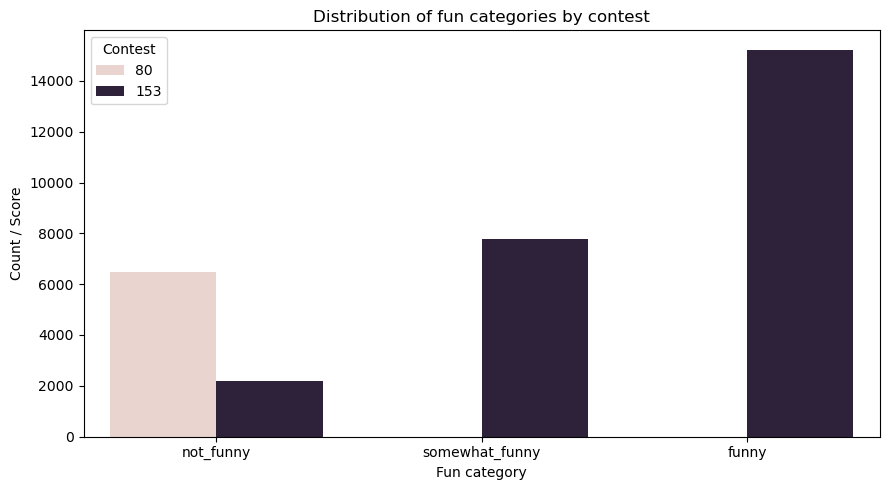

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))

sns.barplot(
    data=df_long,
    x="funny_category",
    y="value",
    hue="source_id",
    dodge=True,
    ci=None
)

plt.xlabel("Fun category")
plt.ylabel("Count / Score")
plt.title("Distribution of fun categories by contest")
plt.legend(title="Contest")

plt.tight_layout()
plt.show()

In [197]:
df_long.dtypes
df_long["funny_category"] = pd.Categorical(
    df_long["funny_category"],
    categories=["not_funny", "somewhat_funny", "funny"],
    ordered=True
)
df_long["source_id"] = pd.Categorical(
    df_long["source_id"]
)
df_long.dtypes

source_id         category
funny_category    category
value                int64
dtype: object

In [ ]:
import plotly.express as px

colors = {"80": "orange", "153": "green"}
messages = {"80": "This is the first contest!", "153": "This is the second contest!"}

fig = px.bar(
    df_long,
    x="funny_category",
    y="value",
    #color="source_id",
    marker_color=colors[source],
    barmode="group",
    color_discrete_map={
        "80": "red",
        "153": "green"
    },
    hover_data={
        "funny_category": True,
        "value": True,
        "source_id": True 
    }
)
fig.update_traces(
    hovertemplate="<b>Funny Category:</b> %{x}<br>" +
                  "<b>Value:</b> %{y}<br>" +
                  "<b>Message:</b> Lunch is on me.<extra></extra>"
)
fig.update_layout(
    title="Votes ditribution for the best and worst captions",
    xaxis_title="Fun category",
    yaxis_title="Value",
    template="plotly_white"
)

fig.show()

In [ ]:
import plotly.express as px

# Ajouter une colonne avec le message dynamique
df_long["hover_message"] = df_long["source_id"].map({
    "80": "This is the first contest!",
    "153": "This is the second contest!"
})

colors = {"80": "orange", "153": "green"}

fig = px.bar(
    df_long,
    x="funny_category",
    y="value",
    color="source_id",  # indispensable pour que PX fasse les barres côte à côte
    barmode="stack",  # ou 'group' pour côte à côte
    color_discrete_map=colors,
    hover_data={
        "funny_category": True,
        "value": True,
        "hover_message": True  # utiliser la colonne message
    }
)

# Personnaliser hover pour avoir seulement ce qu'on veut
fig.update_traces(
    hovertemplate="<b>Funny Category:</b> %{x}<br>" +
                  "<b>Value:</b> %{y}<br>" +
                  "<b>Message:</b> %{customdata[2]}<extra></extra>"
)

fig.update_layout(
    title="Votes distribution for the best and worst captions",
    xaxis_title="Fun category",
    yaxis_title="Value",
    template="plotly_white",
    showlegend=False
)

fig.show()


In [204]:
import plotly.graph_objects as go

fun_categories = ["not_funny", "somewhat_funny", "funny"]
colors = {"80": "orange", "153": "green"}
messages = {"80": "This is the first contest!", "153": "This is the second contest!"}

fig = go.Figure()

for fc in fun_categories:
    for source in ["80", "153"]:
        subset = df_long[(df_long["funny_category"] == fc) & (df_long["source_id"] == source)]
        fig.add_trace(
            go.Bar(
                x=[fc],
                y=subset["value"],
                name=f"{source}",
                marker_color=colors[source],
                offsetgroup=fc,
                hovertemplate=(
                    f"<b>Funny Category:</b> %<br>"
                    f"<b>Value:</b> %<br>"
                    f"<b>Message:</b> {messages[source]}<extra></extra>"
                )
            )
        )

fig.update_layout(
    barmode="group",
    title="Comparison of Fun Categories",
    xaxis_title="Funny category",
    yaxis_title="Value",
    template="plotly_white"
)

fig.show()


## 5. Text : What is funny ? 

How funny do you think you are : which of this two is the most funny 

Welcome in this section, we will try to undercover some of the mechansims of the fun together. But to start lets look at two contests and captions related to them: .

Do you think one of them is funnier? Remember what are you're feeling about them before unfolding the following text.

If now We tell you that you looked at the best and the worth captions of the all contest, 14years taken into account , that one of them was actually voted 6467 not funny and never funny or somewhat funny. and that the other one was voted 15232 times funny see plots, are you surprised? 
If yes then you are experiencing how humor is subjetive. As this dataset was created on a certain population, at a certain time and that player may have seen a lot of repetition in other captions, there votes may changes over time. With this in mind we now know we are not analysing the sacrosain fun, we are analyzing the specific mecansims that explain fun in the context of written caption about a same images. over a population english speaking between 2016 et 2024. So I'm sorry to tell you but you will not learn how to be funny at your next family gathering but it's still worth looking into the data :

Well well lets see if we can learn something about what makes a captions funny:

from the 2 captions presented before we could try to look for diffference that would explain this differences, the first one maybe is how the funny one is short, while the second one is longer, Is this saying something? Let's look at more data to answer this !

Data : To answer this let's take the best of the best and the worth of the worth, this means taking the quantile(0.0001) and 0.9999. This result in groups of funny and not funny of respectively 231 and 230 captions. In addition to testing the difference in number of words lets also look at sentiment polarity-if the words are positive or negative, the subjectivity , number of puctiation,  and the number of repetition.

The result are displayed in the folowing figures. For polarity both group have a mean around 0 showing neutral word were used, with more variance fore the unfinny group. The subjectivity show significant different mean between th group with showing that funny captions tend to be more objective statement. For the Number of words, punctiations and repetion there is no differnece in the distribution or the mena between the groups. 

One thing we can notice here is that all worst captions come from only 4 differents images, maybe the images wasn't funny or people were really anoid so voted heavely for not funny this weeks, however let's look at the data in another point of view : let's take the best and the worst of all contest and compare this :
WOW! We no longer have significant differnec for subjectivity yet now we observe one for the word number and the punctioantion. The funnier caption indeed to be shorter with a median of 10 number of words !









### V2 :
Welcome to this section, where we explore some of the mechanisms behind humor.
Let’s start with a simple question.

Here are two captions from two different contests.
Which one do you find funnier?

Take a moment to trust your first reaction before we go any further.

Now, imagine we tell you that these captions correspond to the best and the worst captions across all contests over 14 years. One of them received 6,467 votes for “not funny”, and the other 15,232 votes for “funny”.
Are you surprised?

If yes, you are already experiencing one key result of this study: humor is subjective. Votes depend on the population, the time period, and even on repetition effects—players may have seen similar jokes many times before.
We now get that it's hard to measure “absolute funniness,” and that's not what we aim to do, this section will rather uncover what makes a caption funny in the specific context of written captions for the same images, evaluated by an English-speaking online community between 2016 and 2024.

#### What makes a caption funny?

Looking at the two captions shown earlier, the first noticeable difference is length: the funnier one is shorter.
Is this a general pattern? Let’s find out by comparing the very funniest and very least funny captions, using the extreme quantiles (0.9999 and 0.0001). This gives us two balanced groups of about 230 captions each. We then compare several features and the results are shown in the following figures: 

- Both groups use mostly neutral words, although the least funny captions show more variability. 
- Subjectivity differs significantly: funny captions tend to be more objective. 
- No clear differences in word count, punctuation.

Was our first intuition wrong? well maybe not totally, if we look at our unfunny group we discover that all captions comes from only 4 contest, very close in time, suggesting that image context may strongly influence voting behavior and could affect our analyses.Another approach is to conduct the same analyses but on the best and worst caption of each contest! This time, the picture changes. Subjectivity is no longer significant, but word count and punctuation become important. The funniest captions are indeed shorter, with a median length of around 10 words. 

### MA partie result :


In [ ]:
# import axe 1
from tqdm import tqdm
from textblob import TextBlob
import re
from scipy.stats import anderson
from scipy.stats import ttest_ind



## 2.1. Axis 1 – What Is Considered Funny

### 2.1.1 : Katia's wonderful work
#### a. Data preparation
The data were aggregated to create a large dataset containing all captions. To keep track of which dataset each caption comes from, we added a source_id column. We then used TextBlob to extract textual features from the captions, such as word count, punctuation count, repetitions, polarity, and subjectivity.

Since this processing step is time-consuming and involves a large dataset, we chose not to load it directly in this notebook. Instead, we include the code in comment and the figures that were generated and saved beforehand in order to reduce the size of the Jupyter notebook. All of this analysis was carried out in the notebook P3_what_is_funny, located in the katia_analysis folder.

In [ ]:
"""
dataA = data['dataA']

dfs_with_id = [
    df.assign(source_id=i)   # add columns with ID of original dataset 
    for i, df in enumerate(dataA)
]
dataAm2 = pd.concat(dfs_with_id, ignore_index=True)
dataAm2.sort_values(by='funny_score_scaled', ascending=False, inplace=True)
dataAm2_2=dataAm2.drop_duplicates() # necessary because some captions were duplicated on some dataframes 
results_blob = []

dataAm2_2 = dataAm2_2.reset_index().rename(columns={"index": "caption_id"})
for i, cap in tqdm(zip(dataAm2_2['caption_id'], dataAm2_2['caption']), total=len(dataAm2_2)):
    blob = TextBlob(cap)
    results_blob.append({
        'caption_id': i,
        'polarity': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity,
        'num_words': len(blob.words),
        'num_punct': len(re.findall(r'[^\w\s]', cap)),
        'num_repeats': len(re.findall(r'\b(\w+)\s+\1\b', cap.lower()))
    })

df_blob = pd.DataFrame(results_blob)

dataAm_rf = dataAm2_2.merge(df_blob, on="caption_id", how="inner")
dataAm_rf= dataAm_rf[dataAm_rf["num_words"]<80] # remove captions that were badly encoded
"""

#### b. Data exploration and results
We first examined the distribution of the funny score across our dataset. The following plot, together with the results of the Anderson test, shows that the distribution is not normal. It is skewed on both sides, with a stronger skew for larger values.

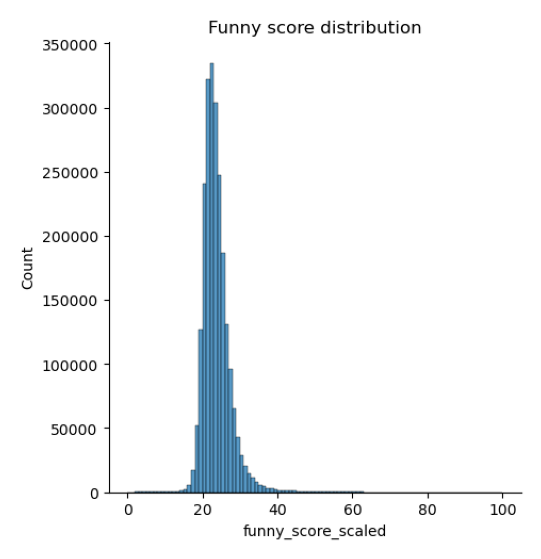

AndersonResult(statistic=np.float64(50595.25888574589), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(23.740472574965178), scale=np.float64(3.7631580153665776))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [43]:
img = plt.imread("plot_result/distribution_funny_score1.1.png")

plt.figure(figsize=(10,7))
plt.imshow(img)
plt.axis("off")
plt.show()

with open("plot_result/anderson_test_results.txt", "r") as f:
    loaded_anderson = f.read()

print(loaded_anderson)


We therefore decided to use quantiles to create groups of the funniest and least funny captions, as this approach does not rely on any assumption about the underlying distribution. We used extreme quantiles at 0.01% which produce group of around 230 captions each.

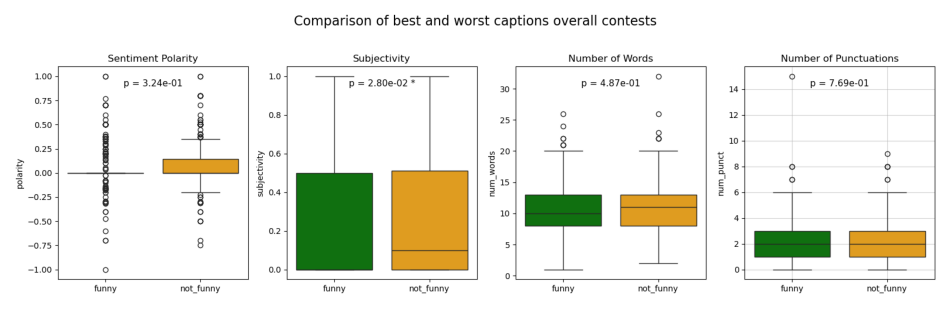

,funny_group3,total_rows,unique_caption
0,funny,231,84
1,mid_funny,2291847,384
2,not_funny,230,4


In [44]:
"""
low_threshold = dataAm_rf["funny_score_scaled"].quantile(0.0001)
high_threshold = dataAm_rf["funny_score_scaled"].quantile(0.9999)
def assign_group(row, high_threshold, low_threshold):
    if row['funny_score_scaled'] >= high_threshold:
        return 'funny'
    elif row['funny_score_scaled'] <= low_threshold:
        return 'not_funny'
    else:
        return 'mid_funny'
dataAm_rf["funny_group3"] = dataAm_rf.apply(assign_group, axis=1, high_threshold=high_threshold, low_threshold=low_threshold)
dataAm_rf_filtered = dataAm_rf[dataAm_rf["funny_group3"] != 'mid_funny']

features = ['polarity', 'subjectivity', 'num_words', 'num_punct']
groups = ['funny', 'not_funny']
ax_one.plot_boxplot_static(
    dataAm_rf_filtered,
    columns_category="funny_group3",
    features=features,
    save_fig=False,
    title="funny_vs_not_funny"
)
"""
img1 = plt.imread("plot_result/bocplot_1.png")

plt.figure(figsize=(12,10))
plt.imshow(img1)
plt.axis("off")
plt.show()
summary_df = pd.read_csv("plot_result/unique_caption_summary.csv")
display(summary_df)

The results indicate that only subjectivity differs significantly between the groups. However, as shown in the table above, the “not funny” group consists of captions from only four contests. This imbalance may bias the results toward the specific themes or styles of these contests rather than reflecting general trends. To address this, we repeated the analysis on a different dataset containing the funniest and least funny captions from each contest, providing a more representative overview across all contests.

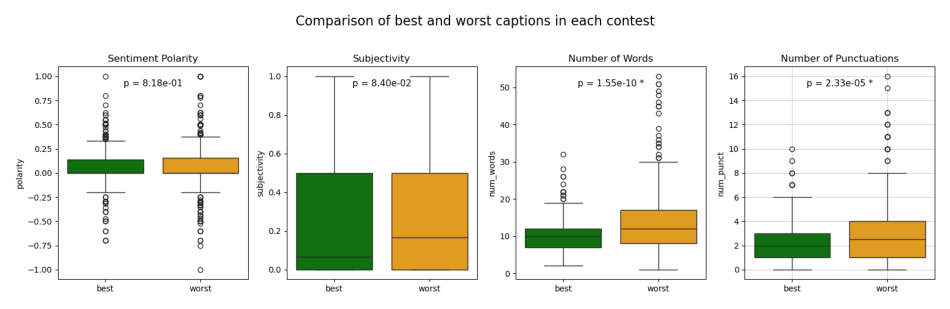

In [32]:
"""
idx_best = dataAm_rf.groupby("source_id")["funny_score_scaled"].idxmax()
idx_worst = dataAm_rf.groupby("source_id")["funny_score_scaled"].idxmin()
df_best = dataAm_rf.loc[idx_best].copy()
df_best["caption_type"] = "best"

df_worst = dataAm_rf.loc[idx_worst].copy()
df_worst["caption_type"] = "worst"
df_combined = pd.concat([df_best, df_worst], ignore_index=True)

ax_one.plot_boxplot_static(
    df_combined,
    columns_category="caption_type",
    features=features,
    save_fig=False,
    title="best_vs_worst"
)
"""
img1 = plt.imread("plot_result/boxplot_2.png")

plt.figure(figsize=(12,10))
plt.imshow(img1)
plt.axis("off")
plt.show()

The results now show significant differences in both the number of words and punctuation, with funnier captions tending to be shorter.

#### c. Funny prediction

To assess fun, we also performed logistic regression on the best and worst captions for each cartoon dataset. 

First, the data were standardized, and the best and worst categories were converted into a binary format. We then used the statsmodels package to fit a logistic regression model, with the target variable being whether a caption is funny (1) or not funny (0). The predictors included same features as before : word count, punctuation, polarity, subjectivity, and repetitions.


In [ ]:
"""
df_combined.loc[:, "category"] = np.where(df_combined['caption_type'] == "best", '1', '0')

cols_to_standardize = ["num_words", "polarity", "subjectivity","num_repeats","num_punct"]
df = df_combined.copy()
for col in cols_to_standardize:
    df[col] = (df[col] - df[col].mean()) / df[col].std()
df["category"] = df["category"].astype(int)

mod = smf.logit(formula='category ~  num_words + polarity + subjectivity + num_repeats + \
                        num_punct ', data=df)
res = mod.fit()
print(res.summary())
"""


In [42]:
with open("plot_result/logit_summary.txt", "r") as f:
    loaded_summary = f.read()

print(loaded_summary)

                           Logit Regression Results                           
Dep. Variable:               category   No. Observations:                  768
Model:                          Logit   Df Residuals:                      762
Method:                           MLE   Df Model:                            5
Date:                Sat, 20 Dec 2025   Pseudo R-squ.:                 0.04416
Time:                        18:00:16   Log-Likelihood:                -508.83
converged:                       True   LL-Null:                       -532.34
Covariance Type:            nonrobust   LLR p-value:                 5.650e-09
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0238      0.075     -0.317      0.751      -0.171       0.123
num_words       -0.5159      0.109     -4.712      0.000      -0.730      -0.301
polarity        -0.0134      0.076     -0.17

The results show that the model explains only a small portion of the variance, with a pseudo R² of just 4%. Among the predictors, the number of words is the only feature with a significant p-value. Its negative coefficient indicates that longer captions tend to be perceived as less funny. This finding is consistent with our previous analysis. However, unlike before, the number of punctuation marks no longer appears to have a significant effect. The second most influential feature here is the number of repetition.

### c.bis Prediction over larger dataset

Other models, including additional logistic regressions and a random forest, were also tested on a larger dataset (around 132996 captions in total). These models were not able to explain more of the variance, in fact, they accounted for even less. This highlights the high variability in the dataset and that it is hard to predict fun with the few simple features given here!